In [14]:
import os
import json
import random
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Union
from rasterio.features import geometry_mask
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_geom

In [15]:
src_path= './data/1164.tif'
data = rasterio.open(src_path)
type(data)
data.profile
data.bounds
data.lnglat()

(29.72482106988837, -2.3369034167595393)

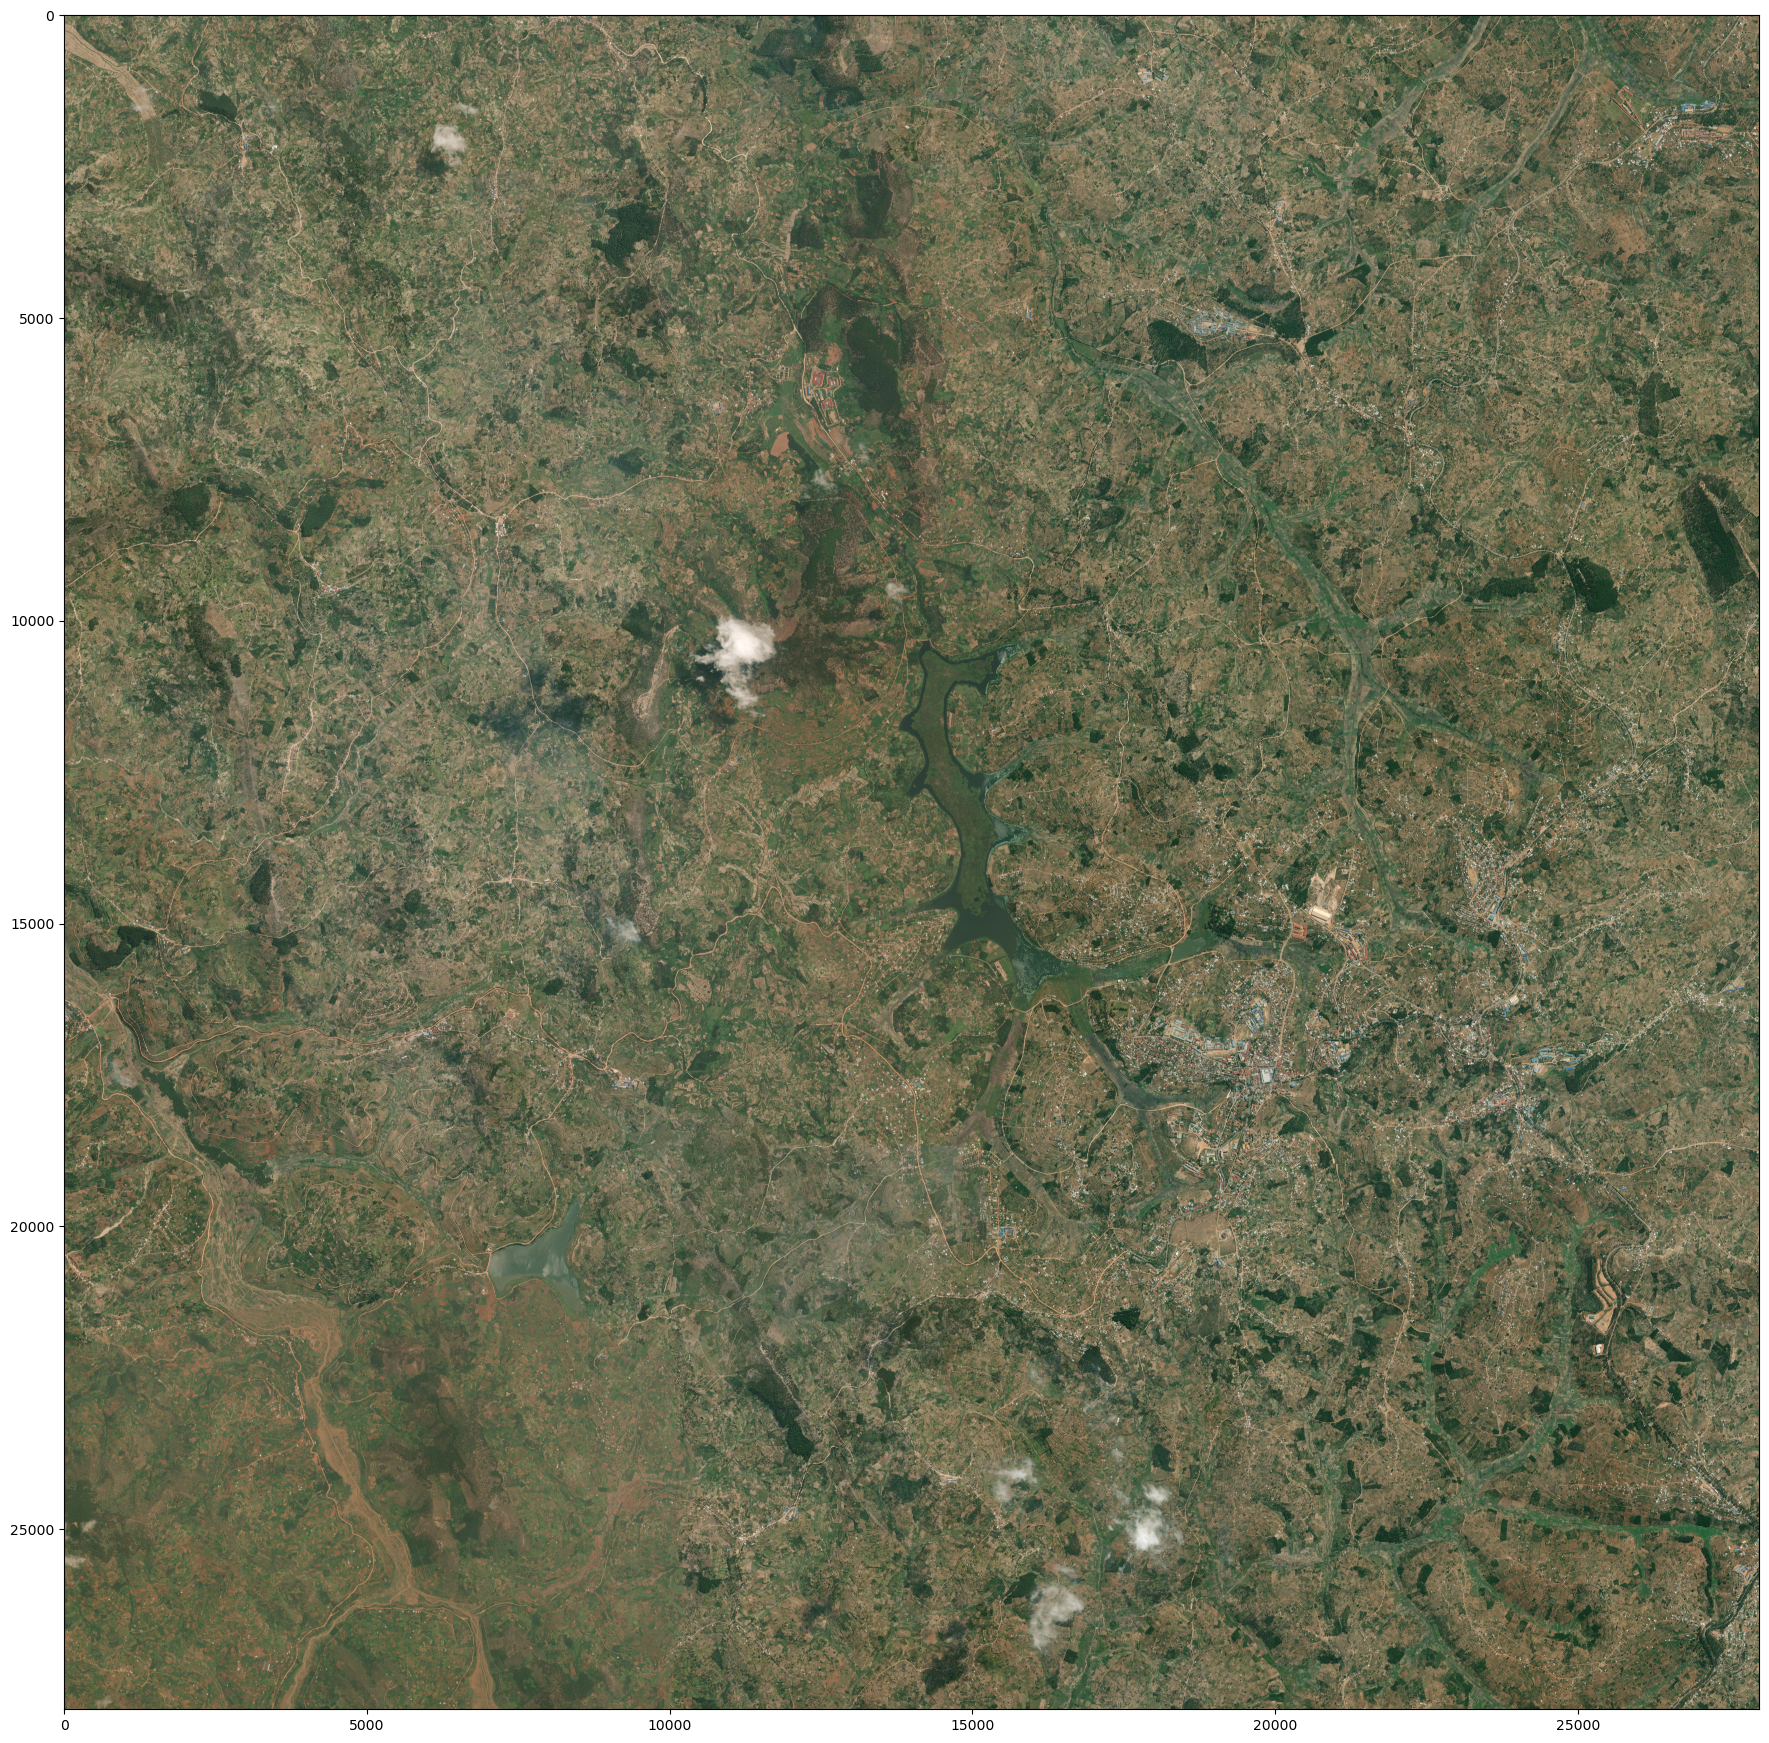

In [16]:
plt.figure(figsize=(22, 22))
plt.imshow(data.read([1,2,3]).transpose(1, 2, 0))

In [17]:
dst_image_dir = 'test_data'

os.makedirs(dst_image_dir, exist_ok=True)

In [18]:
i = 0
city = src_path.split("/")[-3]
code = src_path.split("/")[-2]

In [19]:
def get_tile_name_path(dst_dir:str, index:int, city:str, code:str):
    '''
    Generating index-specific tile name and path
    '''
    dst_tile_name = f"{city}_{code}_{str(index).zfill(5)}.tif"
    dst_tile_path = os.path.join(dst_dir, dst_tile_name)
    return dst_tile_name, dst_tile_path


In [20]:
def get_tile_transform(parent_transform, pixel_x: int, pixel_y: int):
    '''
    Creates a tile transform matrix from the parent TIFF image
    '''
    crs_x = parent_transform.c + pixel_x * parent_transform.a
    crs_y = parent_transform.f + pixel_y * parent_transform.e
    tile_transform = rasterio.Affine(parent_transform.a, parent_transform.b, crs_x,
                                     parent_transform.d, parent_transform.e, crs_y)
    return tile_transform

In [21]:
def get_tile_profile(parent_tif: rasterio.io.DatasetReader, pixel_x: int, pixel_y: int):
    '''
    Prepares the tile profile
    '''
    tile_crs = parent_tif.crs
    tile_nodata = parent_tif.nodata if parent_tif.nodata is not None else 0
    tile_transform = get_tile_transform(parent_tif.transform, pixel_x, pixel_y)
    profile = dict(
        driver="GTiff",
        crs=tile_crs,
        nodata=tile_nodata,
        transform=tile_transform
    )
    return profile

In [22]:
def generate_tiles(tif: rasterio.io.DatasetReader, size: int, dst_dir: str):
    i = 0
    for y in tqdm(range(0, tif.height, size)):
        for x in range(0, tif.width, size):
            # Creating the tile-specific profile
            profile = get_tile_profile(tif, x, y)

            # Extracting the pixel data
            tile_data = tif.read(window=((y, y + size), (x, x + size)),
                                 boundless=True, fill_value=profile['nodata'])[:3]
            i += 1
            dst_name, dst_tile_path = get_tile_name_path(dst_image_dir, i, city, code)
            c, h, w = tile_data.shape
            profile.update(
                height=h,
                width=w,
                count=c,
                dtype=tile_data.dtype,
                tiled='yes',
                blockxsize=size,
                blockysize=size,
                compress='lzw'
            )
            with rasterio.open(dst_tile_path, "w", **profile) as dst:
                dst.write(tile_data)
            # Rename the tile file to include the ID in the file name
            new_dst_tile_name = f"{city}_{code}_{str(i).zfill(5)}.tif"
            new_dst_tile_path = os.path.join(dst_dir, new_dst_tile_name)
            os.rename(dst_tile_path, new_dst_tile_path)

In [23]:
with rasterio.open(src_path) as tif:
    # Call the generate_tiles function
    generate_tiles(tif, size=224, dst_dir=dst_image_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 125/125 [1:20:16<00:00, 38.53s/it]


In [13]:
for index in random.sample(range(754), 10):
    name_index = "{}_{}_{}.tif".format(city, code, str(index).zfill(5))
    img_tile = rasterio.open(os.path.join(dst_image_dir, name_index))

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(img_tile.read().transpose(1, 2, 0))
    plt.subplot

RasterioIOError: NewImages/airport\._data_00319.tif: No such file or directory